# Facility Location for floating markets using PuLP and UrbanPy

### General imports

In [105]:
import sys
sys.path.append('..')
import urbanpy as up
import pandas as pd
import geopandas as gpd
import numpy as np
import re
from pulp import *

### Data preparation

First, we need our set of possible facilities to activate. To construct it we will

* Download a polygon from a Lima district
* Get its bounds
* Download data from possible parks and pitches

In [2]:
sjl = up.download.download_osm(0, 'San Juan de Lurigancho, Lima')

In [3]:
bounds = sjl.total_bounds

In [4]:
nodes, ways = up.download.download_overpass_poi(bounds, 'parks_pitches')

We need to process the polygon data, getting the centroid is a good approximation

In [5]:
ways['lat'] = ways.geometry.centroid.y
ways['lon'] = ways.geometry.centroid.x

Construct the final candidate set from Overpass POIs

In [6]:
candidates = pd.concat([nodes[['id', 'lat', 'lon']], ways[['id', 'lat', 'lon']]])
candidates = gpd.GeoDataFrame(candidates, geometry=gpd.points_from_xy(candidates['lon'], candidates['lat']))
candidates.crs = 'EPSG:4326'

In [7]:
candidates.head()

,id,lat,lon,geometry
0,6129747658,-11.878377,-77.016364,POINT (-77.01636 -11.87838)
1,67624202,-11.985354,-77.014213,POINT (-77.01421 -11.98535)
2,67624203,-11.985472,-77.014529,POINT (-77.01453 -11.98547)
3,67624204,-11.985367,-77.014139,POINT (-77.01414 -11.98537)
4,67626150,-11.986800,-77.010059,POINT (-77.01006 -11.98680)


### Concatenating candidates with the national market census

In [8]:
markets = pd.read_csv('input/market_db.csv')

In [9]:
merc = markets[(markets['DISTRITO'] == 'SAN JUAN DE LURIGANCHO              ')][['longitude', 'latitude']]

In [10]:
merc.reset_index(inplace=True)
merc = gpd.GeoDataFrame(merc, geometry=gpd.points_from_xy(merc['longitude'], merc['latitude']))

In [11]:
merc.crs = 'EPSG:4326'

In [12]:
merc = merc.rename(columns={'index': 'id', 'longitude': 'lon', 'latitude': 'lat'})

In [13]:
candidates = candidates[['id', 'lat', 'lon', 'geometry']]

In [14]:
candidates = gpd.GeoDataFrame(pd.concat([candidates, merc])).reset_index(drop=True)

In [15]:
candidates.head()

,id,lat,lon,geometry
0,6129747658,-11.878377,-77.016364,POINT (-77.01636 -11.87838)
1,67624202,-11.985354,-77.014213,POINT (-77.01421 -11.98535)
2,67624203,-11.985472,-77.014529,POINT (-77.01453 -11.98547)
3,67624204,-11.985367,-77.014139,POINT (-77.01414 -11.98537)
4,67626150,-11.986800,-77.010059,POINT (-77.01006 -11.98680)


### Creating the demand an "clients" for the FLP

Now, we need to estimate the total population moving to these markets. To achieve this we need to

* Download HDX data
* Filter it to our district
* Convert it to hexagons

In [16]:
pop = up.download.download_hdx("4e74db39-87f1-4383-9255-eaf8ebceb0c9/resource/317f1c39-8417-4bde-a076-99bd37feefce/download/population_per_2018-10-01.csv.zip")

In [17]:
pop_sjl = up.geom.filter_population(pop, sjl)

In [18]:
hex_sjl, hex_sjl_centroids = up.geom.gen_hexagons(8, sjl)

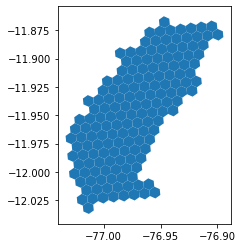

In [19]:
hex_sjl.plot()

Merging both layers

In [20]:
hex_sjl = up.geom.merge_shape_hex(hex_sjl, 
                   pop_sjl, 
                   how='inner', 
                   op='intersects', 
                   agg={'population_2020': 'sum'})

In [21]:
hex_sjl.fillna(0, inplace=True)

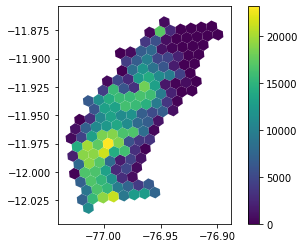

In [22]:
hex_sjl.plot(column='population_2020', legend=True)

## Distance matrix calculation

To estimate the cost for our FLP, we will use walking travel time. For this we need to

* Setup the OSRM server
* Get the distance matrix
* Shutdown the server

In [23]:
up.routing.setup_osrm_server('peru', True)

In [25]:
dmat = up.routing.compute_osrm_dist_matrix(hex_sjl_centroids, candidates, 'walking')

160it [28:04, 10.53s/it]


In [26]:
up.routing.stop_osrm_server()

In [28]:
distance, duration = dmat

In [44]:
cost_mat = duration.T

### Constructing PuLP sets and variables

Set an the number of facilities to be activated

In [67]:
p = 12

Build the facility and customer set as lists, as per PuLP requirements

In [71]:
customers = list(hex_sjl_centroids.index)
facilities = [f'FAC_{i}' for i in candidates.index]

Now we create dictionaries for the demand and cost, associating each customer (hexagon) to the demand (population) and each facility (park/pitch) the respective cost (travel time) to each customer 

In [72]:
demand = {i: hex_sjl.loc[i, 'population_2020'] for i in hex_sjl.index}
cost_dict = {facilities[i]: {customers[j]: cost_mat[i][j] for j in hex_sjl.index} for i in candidates.index}

Crete problem variable for PuLP

In [73]:
prob = LpProblem('FLP_Markets_SJL', LpMinimize)

We create the decision variable $x_{ij}$, representing the percentage of service assigned from a facility to a customer, setting 0 as the lower bound

In [74]:
x = LpVariable.dicts('Service', 
                    [(i,j) for j in customers for i in facilities],
                    0)

Now we create the decision variable to activate a facility $y_i$

In [75]:
y = LpVariable.dicts('Activation',
                     facilities,
                     0,1, LpBinary)

Setting the objective function $$ \sum_{i=1}^{n} \sum_{j=1}^{m} d_{j} c_{ij} x_{ij} $$

In [76]:
prob += lpSum(lpSum(demand[j]*cost_dict[i][j]*x[i,j] for i in facilities) for j in customers)

We add the first constraint $$ \sum_{i=1}^{n} x_{ij} = 1 \quad \forall j \in \text{Customers}$$

In [77]:
for j in customers:
    prob += lpSum(x[i,j] for i in facilities) == 1

Adding the second constraint $$ \sum_{i=1}^{n} y_{i} = p $$

In [78]:
prob += lpSum(y[i] for i in facilities) == p

Third constraint $$ x_{i,j} ≤ y_{i} \quad \forall i \in \text{Facilities} \quad \forall j \in \text{Customers}$$

In [79]:
for i in facilities:
    for j in customers:
        prob += x[i,j] <= y[i]

Write the problem to a .lp file (optional)

In [81]:
prob.writeLP("FLP_Markets_SJL.lp");

Solve (a custom solver may be added in the solve method)

In [82]:
prob.solve()

1

Check solution status

In [83]:
print("Status:", LpStatus[prob.status])

Status: Optimal


Obtain the demand assignments

In [104]:
x_vars = [[0 for j in range(len(customers))] for i in range(len(facilities))]

for v in prob.variables():
    if 'Activation' not in v.name:
        i, j = re.findall('\d+', v.name)
        x_vars[int(i)][int(j)] = v.varValue

In [107]:
y_vars = [v.varValue for v in prob.variables() if 'Activation' in v.name]

In [108]:
x_vars, y_vars = np.array(x_vars), np.array(y_vars)